### 1 - Import test data

In [1]:
import pandas as pd
import pandas_ta as ta

# XAUUSD 2001-2024
df = pd.read_csv("XAUUSD_Candlestick_1_D_BID_03.06.1999-27.04.2024.csv")
df["Gmt time"] = df["Gmt time"].str.replace(".000","", regex=True)
df["Gmt time"] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S')
df = df[df.High != df.Low]
df.reset_index(inplace=True, drop=True)
df["ATR"] = ta.atr(df.High, df.Low, df.Close, length=7)

In [2]:
# indicator rolling max, min, avg
def rolling_max(df, column_name='High', window_size=10, new_column_name='RollingMax'):
    df[new_column_name] = df[column_name].shift(0).rolling(window=window_size).max()
    return df

def rolling_min(df, column_name='Low', window_size=10, new_column_name='RollingMin'):
    df[new_column_name] = df[column_name].shift(0).rolling(window=window_size).min()
    return df

def rolling_avg(df, column1, column2, new_column_name='RollingAvg'):   
    df[new_column_name] = (df[column1] + df[column2]) / 2.0    
    return df

# price open high low close
# (close - r avg n) / (r max n - r min n)
def scaled_price(df, close_column='Close', avg_column='RollingAvg', max_column='RollingMax', min_column='RollingMin', new_column_name='ScaledPrice'):
    df[new_column_name] = (df[close_column] - df[avg_column]) / (df[max_column] - df[min_column])
    
    return df

In [4]:
N = 25
df = rolling_max(df, 'High', N, 'RollingMax')
df = rolling_min(df, 'Low', N, 'RollingMin')
df = rolling_avg(df, 'RollingMax', 'RollingMin')
df = scaled_price(df)

In [5]:
df.describe()

,Open,High,Low,Close,Volume,ATR,RollingMax,RollingMin,RollingAvg,ScaledPrice
count,7136.000000,7136.000000,7136.000000,7136.000000,7.136000e+03,7129.000000,7112.000000,7112.000000,7112.000000,7112.000000
mean,1146.975580,1154.377074,1139.443156,1147.197913,1.801415e+08,14.976460,1188.218124,1104.944247,1146.581185,0.042775
std,528.255523,531.136994,525.111829,528.308118,5.341592e+08,8.598261,542.135555,508.071863,524.694805,0.299508
min,255.300000,258.300000,254.100000,255.300000,1.128000e+04,1.800364,265.200000,254.100000,259.950000,-0.552632
25%,653.780750,657.879750,650.015000,653.757500,9.512680e+06,8.913828,677.330000,631.853000,658.489750,-0.229725
50%,1232.993500,1240.772500,1226.595000,1233.252500,2.901623e+07,14.159842,1270.222000,1196.195000,1235.932000,0.057869
75%,1581.914250,1593.037750,1571.602250,1582.253750,6.107526e+07,19.666797,1629.483000,1526.925000,1585.979000,0.325612
max,2387.635000,2431.385000,2381.275000,2390.295000,1.301699e+10,66.341724,2431.385000,2187.225000,2309.305000,0.500000


In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

st = 300
dfsample = df[st:st+300]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Candlestick(x=dfsample.index,
                             open=dfsample['Open'],
                             high=dfsample['High'],
                             low=dfsample['Low'],
                             close=dfsample['Close'],
                             # SKY BLUE 1.0
                             increasing=dict(line=dict(color='rgba(135, 206, 235, 1.0)', width=0.1),
                                             fillcolor='rgba(135, 206, 235, 1.0)'),
                             # RED 1.0
                             decreasing=dict(line=dict(color='rgba(255, 0, 0, 1.0)', width=0.1),
                                             fillcolor='rgba(255, 0, 0, 1.0)')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['RollingMax'],
                         line=dict(color='red', width=2),
                         name="Rolling Max"),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['RollingMin'],
                         line=dict(color='blue', width=2),
                         name="Rolling Min"),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['RollingAvg'],
                         line=dict(color='yellow', width=2),
                         name="Rolling Average"),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfsample.index, y=dfsample['ScaledPrice'],
                         line=dict(color='purple', width=2),
                         name="Scaled Price"),
              row=2, col=1)

fig.update_layout(
    width=1000,
    height=600,
    sliders=[],
    paper_bgcolor='black',
    plot_bgcolor='black', 
    xaxis_showgrid=False, 
    yaxis_showgrid=False, 
    xaxis_rangeslider=dict(visible=False),
)
fig.show()

In [28]:
def generate_signal(df, threshold1=0.5, threshold2=-0.5, new_column_name='TotalSignal    
    df[new_column_name] = 0
    
    for i in range(1, len(df)):
        if df.loc[i-1, 'ScaledPrice'] < threshold1 and df.loc[i, 'ScaledPrice'] > threshold1:
            df.loc[i, new_column_name] = 2
        elif df.loc[i-1, 'ScaledPrice'] > threshold2 and df.loc[i, 'ScaledPrice'] < threshold2:
            df.loc[i, new_column_name] = 1

    return df

df = generate_signal(df)

In [29]:
df.TotalSignal.value_counts()

0    7133
2       2
1       1
Name: TotalSignal, dtype: int64

In [30]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-4
    elif x['TotalSignal']==1:
        return x['High']+1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=0
dfpl = df[st:st+350]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(x=dfpl.index,
                             open=dfpl['Open'],
                             high=dfpl['High'],
                             low=dfpl['Low'],
                             close=dfpl['Close']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                         marker=dict(size=8, color="MediumPurple"),
                         name="entry"),
              row=1, col=1)

fig.update_layout(width=1200, height=800, sliders=[])
fig.show()

In [34]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[0:]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1
    TPSLRatio = 1.5
    ordertime=[]

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        TPSLRatio = self.TPSLRatio
       
        # if len(self.trades)>0:
        #     if self.data.index[-1]-self.trades[-1].entry_time>=5:
        #         self.trades[-1].close()
        
        if self.signal1==1 and len(self.trades)==0:
            
            for j in range(0, len(self.orders)):
                self.orders[0].cancel()
                self.ordertime.pop(0)

            limit=self.data.High[-1]+self.data.High[-1]*0.01
            sl1 = limit + 0.02*self.data.High[-1]
            tp1 = limit - (sl1-limit)*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize, limit=limit)
            self.ordertime.append(self.data.index[-1])

        elif self.signal1==2 and len(self.trades)==0:            
            for j in range(0, len(self.orders)):
                self.orders[0].cancel()
                self.ordertime.pop(0)
            limit=self.data.Low[-1]-self.data.Low[-1]*0.01         
            sl1 = limit - 0.02*self.data.Low[-1]
            tp1 = limit + (self.data.Close[-1]-sl1)*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize, limit=limit)
            self.ordertime.append(self.data.index[-1])

bt = Backtest(dfopt, MyStrat, cash=25000, margin=1/30, commission=0.0002)
stats, heatmap = bt.optimize(TPSLRatio=[i/10 for i in range(10, 26)],
                        maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

C:\Users\ghwls\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning:

Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.



Loading BokehJS ...

C:\Users\ghwls\AppData\Local\Temp\ipykernel_12740\4078794966.py:48: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

C:\Users\ghwls\anaconda3\Lib\site-packages\backtesting\backtesting.py:912: UserWarning:

(5985) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119



  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\ghwls\anaconda3\Lib\site-packages\backtesting\backtesting.py:912: UserWarning:

(3101) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119

C:\Users\ghwls\anaconda3\Lib\site-packages\backtesting\backtesting.py:912: UserWarning:

(5985) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119

C:\Users\ghwls\anaconda3\Lib\site-packages\backtesting\backtesting.py:912: UserWar

Start                                     0.0
End                                    7135.0
Duration                               7135.0
Exposure Time [%]                    0.938901
Equity Final [$]                 27441.364694
Equity Peak [$]                  29189.216802
Return [%]                           9.765459
Buy & Hold Return [%]              769.672558
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -10.58895
Avg. Drawdown [%]                   -3.577027
Max. Drawdown Duration                 3068.0
Avg. Drawdown Duration                  426.8
# Trades                                  3.0
Win Rate [%]                        33.333333
Best Trade [%]                        8.23373
Worst Trade [%]                     -2.039794
Avg. Trade [%]                    

In [35]:
heatmap

TPSLRatio
1.0         -3.121400
1.1         -2.368207
1.2         -1.456118
1.3         -0.544028
1.4          0.209165
1.5          1.121254
1.6          2.033343
1.7          2.786537
1.8          3.698626
1.9          4.610715
2.0          5.363909
2.1          6.275998
2.2          7.188087
2.3          7.941280
2.4          8.853370
2.5          9.765459
Name: Return [%], dtype: float64

In [36]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[0:]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1
    slcoef = 1.1
    TPSLRatio = 1.5
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio
       
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=25000, margin=1/30, commission=0.0002)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 21)],
                    TPSLRatio=[i/10 for i in range(10, 21)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

C:\Users\ghwls\AppData\Local\Temp\ipykernel_12740\321443345.py:32: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



  0%|          | 0/13 [00:00<?, ?it/s]

Start                                     0.0
End                                    7135.0
Duration                               7135.0
Exposure Time [%]                    0.154148
Equity Final [$]                 28718.789783
Equity Peak [$]                  28718.789783
Return [%]                          14.875159
Buy & Hold Return [%]              769.672558
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.085641
Avg. Drawdown [%]                   -1.085641
Max. Drawdown Duration                    3.0
Avg. Drawdown Duration                    3.0
# Trades                                  3.0
Win Rate [%]                            100.0
Best Trade [%]                       2.144765
Worst Trade [%]                      1.253714
Avg. Trade [%]                    

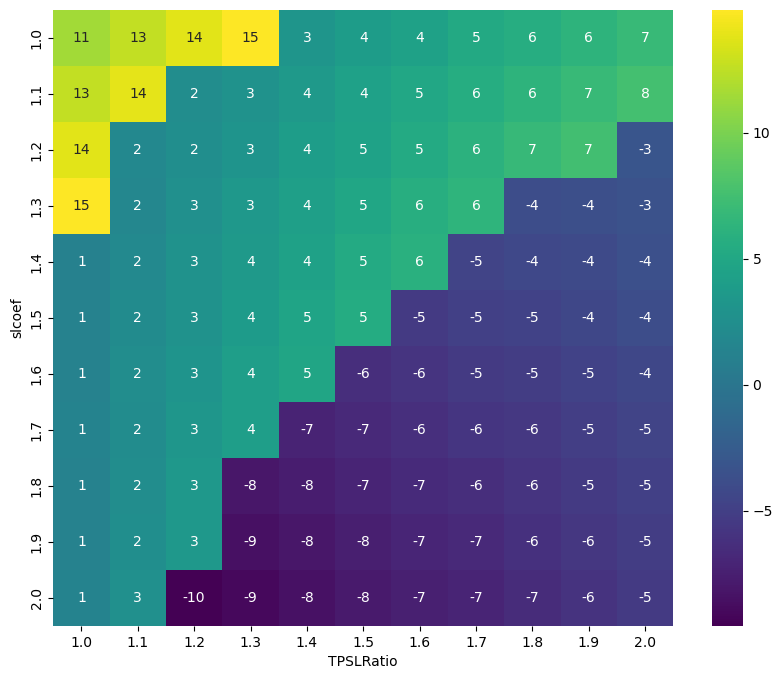

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [38]:
bt.plot()

GridPlot(id='p1307', ...)

In [39]:
heatmap

slcoef  TPSLRatio
1.0     1.0          11.454500
        1.1          12.594720
        1.2          13.734939
        1.3          14.875159
        1.4           3.223830
                       ...    
2.0     1.6          -7.375472
        1.7          -7.099521
        1.8          -6.551663
        1.9          -6.003804
        2.0          -5.455946
Name: Return [%], Length: 121, dtype: float64